In [ ]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [ ]:
gadow_footprints = gpd.read_file("../../data/raw/gadow-builings.gpkg", )
gadow_footprints_area = gadow_footprints[['area', 'geometry']]
gadow_footprints.head()

In [ ]:
wr_heights = gpd.read_file("../../data/raw/centroidy/budynki_.shp")
wr_heights = wr_heights.to_crs(epsg=4326)
wr_heights.head()

In [ ]:
gadow_gdf = ox.geocode_to_gdf('Gądów Mały, Wrocław')
place_proj = ox.project_gdf(gadow_gdf, to_crs='epsg:4326')
gadow_polygon = place_proj.geometry.iloc[0]

In [ ]:
def filter_point_gdf_by_polygon(heights, polygon):
    gadow_heights=[]
    for i, point in heights.iterrows():
        if point['geometry'].within(polygon):
            gadow_heights.append(point)
    return gpd.GeoDataFrame(gadow_heights)
    

In [ ]:
gadow_heights = filter_point_gdf_by_polygon(wr_heights, gadow_polygon)

In [ ]:
gadow_heights

In [ ]:
flow_matrix = pd.read_csv('../../data/interim/flow_matrix_gadow.csv')
flow_matrix["geometry"] = [Point(xy) for xy in zip(flow_matrix['lat'], flow_matrix['long'] )]

In [ ]:
gadow_flow_matrix = filter_point_gdf_by_polygon(flow_matrix, gadow_polygon)

In [ ]:
gadow_flow_matrix

In [ ]:
def map_heights_to_footprint(heights, footprints):
        
    for i_h, height in heights.iterrows():
        for i_f, footprint in footprints.iterrows():
            point = height['geometry']
            if point.within(footprint['geometry']):
                footprints.at[i_f, 'height_sum'] = footprints.at[i_f,'height_sum'] + height['WYS_MAX']
                footprints.at[i_f ,'points_count'] = footprints.at[i_f, 'points_count'] + 1
    return footprints
    

In [ ]:
gadow_footprints['height_sum'] = 0
gadow_footprints['points_count'] = 0

gadow_footprints_mapped = map_heights_to_footprint(gadow_heights, gadow_footprints)

In [ ]:
gadow_footprints_mapped['points_count'].value_counts()

In [ ]:
gadow_footprints_mapped = gadow_footprints_mapped.loc[gadow_footprints_mapped['points_count'] != 0]

In [ ]:
gadow_footprints_mapped['avg_height'] = gadow_footprints_mapped['height_sum'] / gadow_footprints_mapped['points_count']

In [ ]:
gadow_footprints_mapped['avg_height'].hist()

In [ ]:
(gadow_footprints_mapped['area'] * 1_000_000_000 ).hist()

In [ ]:
fig, ax = ox.plot_footprints(gadow_footprints_mapped, dpi=400, close=True)

In [ ]:
# Check how are OSM and BIP data correlated
dr = gadow_footprints_mapped.height.dropna().index.tolist()
gadow_footprints_mapped.loc[dr, ["height","avg_height"]]

In [ ]:
LEVEL_HEIGHT = 2.5
FLAT_SURFACE = 50

In [ ]:
gadow_footprints_mapped["flat_count"] = ((gadow_footprints_mapped['area'] * 1_000_000_000 / FLAT_SURFACE)\
 * (gadow_footprints_mapped.avg_height / LEVEL_HEIGHT)).round().astype(int) + 1
                                            

In [ ]:
gadow_footprints_mapped["flat_count"].hist()

In [ ]:
gadow_footprints_mapped["flat_count"].value_counts()

In [ ]:
gadow_footprints_mapped.to_file('gadow_footprints_mapped.gpkg', driver='GPKG')

In [ ]:
gadow_flow_matrix

In [ ]:
gadow_flow_matrix['building_id'] = -1

In [ ]:
def map_points_to_polygons(points, footprints):
     for i_p, point in points.iterrows():
        for i_f, footprint in footprints.iterrows():
            if point['geometry'].within(footprint['geometry']):
                points.at[i_p, 'building_id'] = i_f
     return points


In [ ]:
gadow_flows_by_buildings = map_points_to_polygons(gadow_flow_matrix, gadow_footprints_mapped)

In [ ]:
gadow_flow_mapped = gadow_flows_by_buildings.loc[gadow_flows_by_buildings['building_id'] != -1]

In [ ]:
unique_stops = gadow_flow_mapped['building_id'].unique()

In [211]:
gadow_unique_stops = gadow_footprints_mapped.loc[unique_stops]

In [ ]:
fig, ax = ox.plot_footprints(gadow_footprints_mapped.loc[unique_stops], dpi=400, close=True)

<AxesSubplot:>

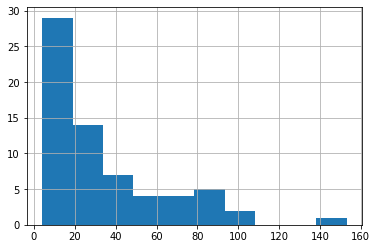

In [213]:

gadow_unique_stops['flat_count'].hist()